In [ ]:
!pip install gcsfs==2024.9.0



Reason for being yanked: requirements incorrect
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 15.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
  Attempting uninstall: gcsfs
    Found existing installation: gcsfs 2024.10.0
    Uninstalling gcsfs-2024.10.0:
      Successfully uninstalled gcsfs-2024.10.0


In [ ]:
!pip install spacy matplotlib networkx datasets pandas tensorflow


In [ ]:
from datasets import load_dataset
import pandas as pd


dataset = load_dataset("ag_news")

train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])

print(train_df.head())


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

                                                text  label
0  Wall St. Bears Claw Back Into the Black (Reute...      2
1  Carlyle Looks Toward Commercial Aerospace (Reu...      2
2  Oil and Economy Cloud Stocks' Outlook (Reuters...      2
3  Iraq Halts Oil Exports from Main Southern Pipe...      2
4  Oil prices soar to all-time record, posing new...      2


The -> det -> company
technology -> compound -> company
company -> nsubj -> releasing
is -> aux -> releasing
releasing -> ROOT -> releasing
a -> det -> product
new -> amod -> product
product -> dobj -> releasing
this -> det -> year
year -> npadvmod -> releasing
. -> punct -> releasing


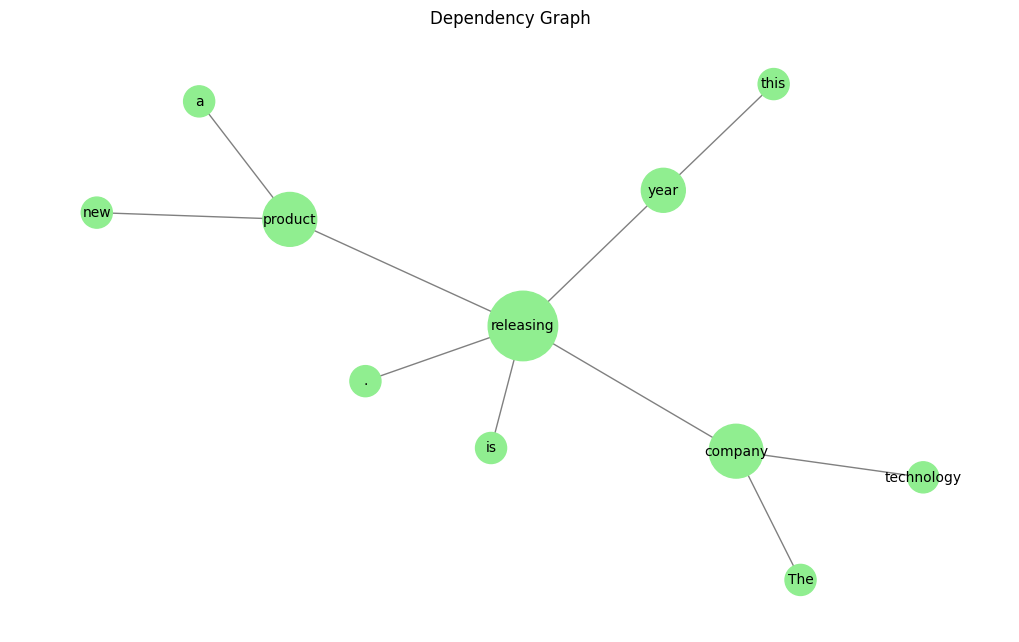

In [ ]:
import spacy
from spacy import displacy
import networkx as nx
import matplotlib.pyplot as plt

nlp = spacy.load("en_core_web_sm")

sample_sentence = "The technology company is releasing a new product this year."
doc = nlp(sample_sentence)

for token in doc:
    print(f"{token.text} -> {token.dep_} -> {token.head.text}")

displacy.render(doc, style="dep", jupyter=True)

graph = nx.Graph()
for token in doc:
    graph.add_node(token.text)
    if token.head.text != token.text:
        graph.add_edge(token.text, token.head.text)

node_sizes = [graph.degree(node) * 500 for node in graph.nodes()]
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(graph)
nx.draw(graph, pos, with_labels=True, node_size=node_sizes, font_size=10, node_color='lightgreen', edge_color='gray')
plt.title("Dependency Graph")
plt.show()


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df["text"].values)

max_sequence_length = 128

X_train = tokenizer.texts_to_sequences(train_df["text"].values)
X_train = pad_sequences(X_train, maxlen=max_sequence_length, padding="post", truncating="post")

X_test = tokenizer.texts_to_sequences(test_df["text"].values)
X_test = pad_sequences(X_test, maxlen=max_sequence_length, padding="post", truncating="post")

y_train = pd.get_dummies(train_df["label"]).values
y_test = pd.get_dummies(test_df["label"]).values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(120000, 128) (120000, 4) (7600, 128) (7600, 4)


In [ ]:
import tensorflow as tf

embedding_dim = 128
num_classes = len(set(train_df['label']))

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length, name="embedding"),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation="relu", padding="same", name="conv1d"),
    tf.keras.layers.GlobalMaxPooling1D(name="pooling"),
    tf.keras.layers.Dense(64, activation="relu", name="dense"),
    tf.keras.layers.Dense(num_classes, activation="softmax", name="output")
])

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

model.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_test, y_test))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pooling (GlobalMaxPooling1D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.8344 - loss: 0.4562 - val_accuracy: 0.9158 - val_loss: 0.2499
Epoch 2/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9433 - loss: 0.1667 - val_accuracy: 0.9167 - val_loss: 0.2562
Epoch 3/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9657 - loss: 0.0988 - val_accuracy: 0.9130 - val_loss: 0.2750
Epoch 4/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9822 - loss: 0.0524 - val_accuracy: 0.9111 - val_loss: 0.3440
Epoch 5/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9887 - loss: 0.0348 - val_accuracy: 0.9126 - val_loss: 0.3842


In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9103 - loss: 0.3920
Test Loss: 0.3842
Test Accuracy: 0.9126


In [ ]:
import numpy as np

def predict_category(text, tokenizer, model, max_sequence_length):
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length, padding="post", truncating="post")

    prediction = model.predict(padded_sequence)

    predicted_label = np.argmax(prediction, axis=1)[0]

    label_map = {0: "World", 1: "Sports", 2: "Business", 3: "Science/Technology"}
    return label_map[predicted_label]

new_input = "The new technology in smartphones has revolutionized mobile communication."
predicted_category = predict_category(new_input, tokenizer, model, max_sequence_length)
print(f"Predicted Category: {predicted_category}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
Predicted Category: Science/Technology
